## Plotting psychometric performance 

The goal of this notebook is to familiarize you with how to plot some basic metrics for psychometric quantification and visualize data.
 

In [9]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
from glob import glob # to search files 

# Note that if you want the plots to be interactive change the %matplotlib option
# the option can be 
#     qt - to use plots in a separate window,
#     notebook to use interactive "widgets" or
#     inline - not interactive
#     widget - interactive on vscode
%matplotlib inline

# Generate the example data from the raw trial log
# filename = '/home/data/JC089/20221118_135951/DropletsTask/JC089_20221118_135951_DropletsTask.triallog.h5'
# session_data = pd.read_hdf(filename) # the task data are in the "triallog.h5" files
# session_data[['itrial','stim_intensity','response']].to_hdf('../example/tutorial1_JC089_20221118.dataset.hdf5','example')

# load the example dataset
session_data = pd.read_hdf("tutorial1_JC089_20221118.dataset.hdf5")
session_data.head() # show the dataframe

,itrial,stim_intensity,response
0,0,-30,1
1,1,30,1
2,2,30,-1
3,3,-30,-1
4,4,30,1


#### Two-alternative visual discrimination task

In the task of the example dataset, the subject is trained to report the side (`left` or `right`) with the highest rate of events. The stimuli appears at the *left*, the *right* or on *both* sides. 

Organization of the `session_data` dataframe:
 - `stim_ intensity`  is the **rate of events shown at the left minus that on the right**.
 - `response` is the actual reported subject response. it is `1` for **leftward choices**, `0` for **no choice** and ``-1`` for **rightward choices**.



In [2]:
ntrials = len(session_data)
print('The subject was doing the task for {0} trials.\n'.format(ntrials))  # the print function lets you display stuff, it is very useful for debugging 

ntrials_with_choice = len(session_data[session_data.response != 0])
print('Out of {0} trial, the subject responded left or right in {1} trials.\n'.format(ntrials,ntrials_with_choice))

unique_stim_intensities = np.sort(session_data.stim_intensity.unique()) # sort the intensities
print('There are {0} stimuli conditions {1} Hz'.format(len(unique_stim_intensities),unique_stim_intensities))


The subject was doing the task for 1158 trials.

Out of 1158 trial, the subject responded left or right in 1158 trials.

There are 8 stimuli conditions [-30 -24 -18 -12  12  18  24  30] Hz


### Plot the response to each trial versus the stimulus intensity
The response to each trial is in the `session_data.response variable`

For visualization purposes we may jitter the points a bit, here we do that by adding uniform noise to the data before plotting. 
That is only for visualization purposes. We also play with the transparency (alpha value) of the points.

In some cases it is useful to look at the responses to each trial during the experiment, lets also look at the data that way (second plot).

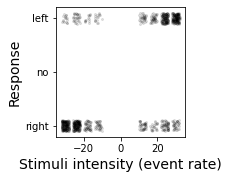

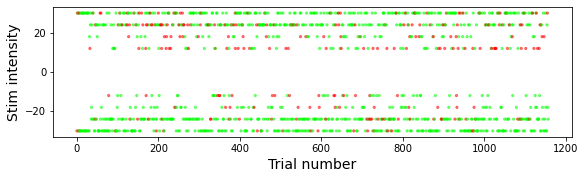

In [4]:
fig = plt.figure(figsize = [3,3]) # creates a figure to plot 3 by 3 inches in this case
ax = fig.add_axes([0.3,0.3,0.6,0.6]) # create the axis in xpos, ypos,width,height
# plot the response
ax.plot(session_data.stim_intensity+np.random.uniform(-2,2,len(session_data)), # the stim_intensities + noise
        session_data.response+np.random.uniform(-0.1,0.1,len(session_data)), # the response -1 (right), 0 or 1 (left)
        'ko',alpha = 0.1, markersize = 2);  # plot with transparency 

ax.set_ylabel('Response',fontsize = 14)  # set the y-axis label and the font size
ax.set_xlabel('Stimuli intensity (event rate)', fontsize = 14) # set the x-axis label
ax.set_yticks([-1,0,1],['right','no','left']);

# Plot also the responses for each trial maintaining the trial identity
fig = plt.figure(figsize = [9,3]) 
ax = fig.add_axes([0.15,0.3,0.8,0.6]) 

# the color is green if the correct response, red if wrong, gray if none
c = []
for s,r in zip(np.array(session_data.stim_intensity),np.array(session_data.response)):
        if ((s>0) & (r>0)) | ((s<0) & (r<0)):
                # then set green
                c.append([0,1,0])
        elif r == 0:
                c.append([0.5,0.5,0.5])
        else:
                c.append([1,0,0])


plt.scatter(np.arange(len(session_data)),session_data.stim_intensity,5,c,alpha = 0.5)
plt.ylabel('Stim intensity',fontsize = 14)
plt.xlabel('Trial number',fontsize = 14);

The subject does a fair amount of incorrect choices, even for easy conditions. 

It is hard to visualize exactly how many with the plot above, lets plot a **histogram of the correct and incorrect responses for each stimulus intensity**.


The correct responses are the junction of left response (i.e. 1) when the stim intensity was left and right response (-1) when the stim was on the right.


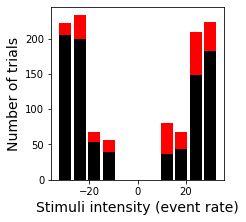

In [5]:
# the correct response are the ones where response and stim_intensity have the same sign
correct_responses = (((session_data.response==1) & (session_data.stim_intensity>0)) |
                     ((session_data.response==-1) & (session_data.stim_intensity<0)))

incorrect_responses = (((session_data.response!=1) & (session_data.stim_intensity>0)) |
                     ((session_data.response!=-1) & (session_data.stim_intensity<0)))

# Unique stim intensities
intensities = np.unique(session_data.stim_intensity)
correct = np.zeros_like(intensities)
incorrect = np.zeros_like(intensities)
# count the trials
for i,intensity in enumerate(intensities):
    correct[i] = np.sum(correct_responses[np.array(session_data.stim_intensity) == intensity])
    incorrect[i] = np.sum(incorrect_responses[np.array(session_data.stim_intensity) == intensity])
# make a figure
fig = plt.figure(figsize = [4,4])
ax = fig.add_axes([0.3,0.3,0.6,0.6])
ax.bar(intensities,correct,width = 5,color = 'black')                # correct choices in BLACK
ax.bar(intensities,incorrect,bottom = correct,width = 5,color='red') # incorrect choices in RED
ax.set_xlabel('Stimuli intensity (event rate)', fontsize = 14) # set the x-axis label
ax.set_ylabel('Number of trials', fontsize = 14) # set the y-axis label
ax.set_xticks([-20,0,20]);


### Plot the psychometric points for these data

The psychometric curve for these data can be plot by looking at the responses to one of the sides (left or right). 

To do this we will plot the fraction of trials of responding left (could also be right) for each stimuli intensity; regardless if the choice was correct or not.

**Note:** To compute the fraction we will use a `for` loop. We will go to each intensity and count the number of trials to the left out of all trials that were done for that intensity.


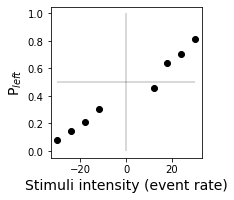

In [6]:
sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)

intensities = np.sort(sel.stim_intensity.unique())  # the stimulus intensity values
p_left = np.zeros_like(intensities,dtype=float)     # pre-allocate the array (fill with zeros when you know the size)
# note that p_left is cast to float so it can take fractional numbers
# this is the part where we estimate the probability of left lick
for i,stim_intensity in enumerate(intensities):
    p_left[i] = np.sum(responded_left[sel.stim_intensity == stim_intensity])/np.sum(sel.stim_intensity == stim_intensity)


# this just plots the result
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.plot(intensities,p_left,'ko')

ax.vlines(0,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(intensities),np.max(intensities),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

ax.set_ylabel('P$_{left}$',fontsize = 14)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimuli intensity (event rate)', fontsize = 14); # set the x-axis label

#### Confidence intervals

We saw above that the not all intensities have the same number of trials, for that reason. Our confidence in each point is not the same; i.e. we should not trust as much in points with less observations. 

We therefore need to compute the confidence interval for each point. Each observation can be a success (correct response) or failure (incorrect response); when that is the case is we can estimate the confidence interval by assuming a binomial distribution.

This assumption is valid when:
 - each trial has 2 outcomes, success or failure
 - the trials/observations are independent
 - the probability of success is the same for each trial
 
There are many ways to estimate the confidence intervals of a binomial distribution. Some ways are better than others. The [Wilson](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) method, developed in 1927 by Edwin Wilson, is a good way of estimating the intervals that works well even when there are not many samples. 

We will use `statmodels` - a python package; to compute the confidence intervals using the **Wilson** method.

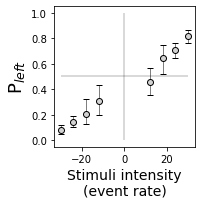

In [7]:
from statsmodels.stats.proportion import proportion_confint  # this will do the heavy lifting

# Again lets select only trials with response (can only have 2 outcomes)
sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)

intensities = np.sort(sel.stim_intensity.unique()).astype(float)  
p_left = np.zeros_like(intensities,dtype=float) 
ci_left = np.zeros((len(intensities),2),dtype=float) # allocate

# use a for loop to actually retrieve the trials.
for i,stim_intensity in enumerate(intensities):
    cnt = np.sum(responded_left[sel.stim_intensity == stim_intensity]) # number of times the subject licked left 
    nobs = np.sum(sel.stim_intensity == stim_intensity) # number of observations (ntrials)
    p_left[i] = cnt/nobs
    ci_left[i] = proportion_confint(cnt,nobs,method='wilson') # 95% confidence interval


fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.25,0.25,0.65,0.65])
ax.vlines(0,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(intensities),np.max(intensities),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

# plot the observed data and confidence intervals
for i,e in zip(intensities,ci_left):  # plot the confidence intervals
    ax.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
ax.plot(intensities,p_left,'ko',markerfacecolor = 'lightgray',markersize = 6)

ax.set_ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimuli intensity\n(event rate)', fontsize = 14); # set the x-axis label


### Using a function to do all the above

In order to ease reproducibility one can also use a function to compute the proportions. You can import the function by `from fit_psychometric import compute_proportions`

The code for the function is in the `analysis.py` file, inside the folder `fit_psychometric`

The function takes as input the stimuli intensities (e.g. contrast, rate...) and the response (0 or 1) to one of the sides.
Outputs:
 - `stims`   - the unique stimuli values
 - `p_side`  - the proportion responses to the chosen side
 - `ci_side` - the confidence intervals to that side
 - `n_obs`   - the number of observations (trials) for each intensity
 - `n_side`  - the number of correct responses for each intensity


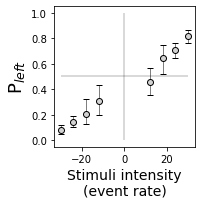

In [8]:
import sys; sys.path.append('..')  # this is not needed if you install the module
from fit_psychometric import compute_proportions

sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)
stim_intensities = sel.stim_intensity


# This is the function that does the actual computing, the rest is trial selection and plotting
stims, p_side, ci_side, n_obs, n_side = compute_proportions(stim_values=stim_intensities, response_values=responded_left)

##############################
########### plotting #########
##############################
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.25,0.25,0.65,0.65])
ax.vlines(0,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(stims),np.max(stims),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

# plot the observed data and confidence intervals
for i,e in zip(stims,ci_side):  # plot the confidence intervals
    ax.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
ax.plot(stims,p_side,'ko',markerfacecolor = 'lightgray',markersize = 6)

ax.set_ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimuli intensity\n(event rate)', fontsize = 14); # set the x-axis label

